# Introduction to text embeddings on S&P 500 news

objectives# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Retrieve Financial News:**
   - Use the `yfinance` library to gather news headlines for all companies in the S&P 500 index.

2. **Clean and Structure Financial Text Data:**
   - Extract and organize relevant metadata (e.g., ticker, title, summary, publication date, URL) into a structured pandas DataFrame.

3. **Generate Text Embeddings:**
   - Apply a pre-trained sentence transformer model (`all-MiniLM-L6-v2`) to convert news headlines and summaries into numerical embeddings.

4. **Apply Clustering Techniques:**
   - Use K-Means clustering to identify groups of similar news articles based on semantic content.

5. **Determine Optimal Number of Clusters:**
   - Evaluate clustering quality using silhouette scores to find the best number of clusters.

6. **Visualize High-Dimensional Embeddings:**
   - Reduce the embedding space using PCA and visualize clusters in two dimensions.

7. **Interpret Cluster Themes:**
   - Analyze representative news


## Install and Import important librairies

In [18]:
%pip install pandas
%pip install yfinance
%pip install lxml
%pip install -U sentence-transformers

In [19]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import yfinance as yf

## Get the list of stocks in the S&P 500

In [20]:
# Read and print the stock tickers that make up S&P500
df_tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

display(df_tickers.head())

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [21]:
ticker_list = df_tickers['Symbol'].tolist()

## Get the news of all 500 stocks in the S&P 500 Index
Use the yfinance library to retrieve the news of all 500 stocks in the index.
https://ranaroussi.github.io/yfinance/reference/yfinance.stock.html

### Get the news in a dictionary

In [22]:
# Create a dictionary where the keys are the symbols (tickers) of each 500 stocks
# and the value is the output news from the yfinance library

# YOUR CODE HERE
news_dict = {}
for ticker in ticker_list:
    try:
        stock = yf.Ticker(ticker)
        news_dict[ticker] = stock.news
    except Exception as e:
        print(f"Could not retrieve news for {ticker}: {e}")

# Display the first few entries to check the structure
print("News dictionary created. Displaying news for the first ticker:")
if ticker_list:
    first_ticker = ticker_list[0]
    if first_ticker in news_dict and news_dict[first_ticker]:
        display(news_dict[first_ticker][0])
    else:
        print(f"No news found for {first_ticker}")
else:
    print("Ticker list is empty.")

ERROR:yfinance:URI: Failed to retrieve the news and received faulty response instead.
ERROR:yfinance:UNH: Failed to retrieve the news and received faulty response instead.
ERROR:yfinance:UHS: Failed to retrieve the news and received faulty response instead.
ERROR:yfinance:VLO: Failed to retrieve the news and received faulty response instead.
ERROR:yfinance:VTR: Failed to retrieve the news and received faulty response instead.
ERROR:yfinance:VLTO: Failed to retrieve the news and received faulty response instead.
ERROR:yfinance:VRSN: Failed to retrieve the news and received faulty response instead.
ERROR:yfinance:VRSK: Failed to retrieve the news and received faulty response instead.
ERROR:yfinance:VZ: Failed to retrieve the news and received faulty response instead.
ERROR:yfinance:VRTX: Failed to retrieve the news and received faulty response instead.
ERROR:yfinance:VTRS: Failed to retrieve the news and received faulty response instead.
ERROR:yfinance:VICI: Failed to retrieve the news a

News dictionary created. Displaying news for the first ticker:


{'id': '2f475c52-e043-3340-9129-7f18b3fdb18d',
 'content': {'id': '2f475c52-e043-3340-9129-7f18b3fdb18d',
  'contentType': 'STORY',
  'title': '3M Company (MMM): “I Was Surprised” By The Organic Growth Rate, Says Jim Cramer',
  'description': '',
  'summary': 'We recently published 12 Stocks Jim Cramer Talked About. 3M Company (NYSE:MMM) is one of the stocks Jim Cramer recently discussed. 3M Company (NYSE:MMM) is one of the largest industrial conglomerates in the world. Its shares have gained 16.7% year-to-date as part of a bullish run in industrial stocks that Cramer has commented on several […]',
  'pubDate': '2025-07-24T09:03:00Z',
  'displayTime': '2025-07-24T09:03:00Z',
  'isHosted': True,
  'bypassModal': False,
  'previewUrl': None,
  'thumbnail': {'originalUrl': 'https://media.zenfs.com/en/insidermonkey.com/093e1a4edd0e304bc17c1f522a735210',
   'originalWidth': 1000,
   'originalHeight': 667,
   'caption': '3M Company (MMM): "I Was Surprised" By The Organic Growth Rate, Says Ji

Depending on the time you retrieve the ticker news, some of them get errors, so we don't get 100% of all tickers to analyze. I got 488 to 493 tickers back each time I ran the code.

### Structure the news into a pandas dataframe

Your final dataframe should have the following columns:
- TICKER
- TITLE (of the news)
- SUMMARY (of the news)
- PUBLICATION_DATE (of the news)
- URL (of the news)

Note: all of those fields are provided in the yfinance news component. Refer to the library documentation.

In [23]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULTS

# Initialize an empty list to store the news data
news_list = []

# Iterate through the news_dict to extract information
for ticker, news_items in news_dict.items():
    for item in news_items:
        # Accessing nested keys
        content = item.get('content', {})
        news_list.append({
            'TICKER': ticker,
            'TITLE': content.get('title', ''),
            'SUMMARY': content.get('summary', ''),
            'PUBLICATION_DATE': pd.to_datetime(content.get('pubDate')),
            'URL': content.get('canonicalUrl', {}).get('url', '') if content.get('canonicalUrl') else content.get('clickThroughUrl', {}).get('url', '')
        })

# Create the pandas DataFrame
news_df = pd.DataFrame(news_list)

# Display the first few rows of the DataFrame
display(news_df.head())

# Display information about the DataFrame
news_df.info()

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24 09:03:00+00:00,https://finance.yahoo.com/news/3m-company-mmm-...
1,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",2025-07-21 09:45:00+00:00,https://finance.yahoo.com/news/zacks-industry-...
2,MMM,"Stock Market News for Jul 21, 2025",U.S. stock markets closed mostly lower n Frida...,2025-07-21 08:22:00+00:00,https://finance.yahoo.com/news/stock-market-ne...
3,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) reports a 12% increase in adjusted...,2025-07-19 07:05:47+00:00,https://finance.yahoo.com/news/3m-co-mmm-q2-20...
4,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,Industrial conglomerate 3M (NYSE:MMM) reported...,2025-07-19 05:30:58+00:00,https://finance.yahoo.com/news/mmm-q1-deep-div...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4590 entries, 0 to 4589
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   TICKER            4590 non-null   object             
 1   TITLE             4590 non-null   object             
 2   SUMMARY           4590 non-null   object             
 3   PUBLICATION_DATE  4590 non-null   datetime64[ns, UTC]
 4   URL               4590 non-null   object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 179.4+ KB


## Exploring text embeddings

- Use the open-source model: 'sentence-transformers/all-MiniLM-L6-v2' to create embeddings on the news title and summary
- Add a column to your news dataframe called EMBEDDED_TEXT using ONLY the TITLE of the news
- Add a column to your news dataframe called EMBEDDINGS, which contains the embedding of EMBEDDED_TEXT


In [24]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Load the sentence transformer model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Add EMBEDDED_TEXT column using only the TITLE
news_df['EMBEDDED_TEXT'] = news_df['TITLE']

# Generate embeddings for the EMBEDDED_TEXT
news_df['EMBEDDINGS'] = news_df['EMBEDDED_TEXT'].apply(lambda x: model.encode(x))

# Display the first few rows with the new columns
display(news_df.head())


,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24 09:03:00+00:00,https://finance.yahoo.com/news/3m-company-mmm-...,3M Company (MMM): “I Was Surprised” By The Org...,"[0.006455427, -0.109047554, -0.07995972, 0.026..."
1,MMM,"Zacks Industry Outlook Highlights Honeywell, 3...","HON, MMM, CSL, and FSS are well-positioned to ...",2025-07-21 09:45:00+00:00,https://finance.yahoo.com/news/zacks-industry-...,"Zacks Industry Outlook Highlights Honeywell, 3...","[-0.0216293, -0.07978322, -0.025434958, 0.0075..."
2,MMM,"Stock Market News for Jul 21, 2025",U.S. stock markets closed mostly lower n Frida...,2025-07-21 08:22:00+00:00,https://finance.yahoo.com/news/stock-market-ne...,"Stock Market News for Jul 21, 2025","[-0.037469547, -0.043813713, 0.02352598, 0.107..."
3,MMM,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,3M Co (MMM) reports a 12% increase in adjusted...,2025-07-19 07:05:47+00:00,https://finance.yahoo.com/news/3m-co-mmm-q2-20...,3M Co (MMM) Q2 2025 Earnings Call Highlights: ...,"[-0.080801524, -0.029800754, -0.03165096, 0.04..."
4,MMM,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,Industrial conglomerate 3M (NYSE:MMM) reported...,2025-07-19 05:30:58+00:00,https://finance.yahoo.com/news/mmm-q1-deep-div...,MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...,"[-0.01950261, -0.07280385, 0.04442304, -0.0564..."


## Using K-means clustering on news embeddings
to simplify, keep only one news for each company (ticker), you should have 500 rows in your news dataframe

In [25]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

news_df_unique = news_df.drop_duplicates(subset=['TICKER'], keep='first').copy()

# Display the shape and head of the new DataFrame to verify
print("DataFrame with unique tickers:")
print(f"Shape: {news_df_unique.shape}")
display(news_df_unique.head())

DataFrame with unique tickers:
Shape: (459, 7)


,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24 09:03:00+00:00,https://finance.yahoo.com/news/3m-company-mmm-...,3M Company (MMM): “I Was Surprised” By The Org...,"[0.006455427, -0.109047554, -0.07995972, 0.026..."
10,AOS,Earnings Beat: A. O. Smith Corporation Just Be...,Investors in A. O. Smith Corporation ( NYSE:AO...,2025-07-27 12:40:47+00:00,https://finance.yahoo.com/news/earnings-beat-o...,Earnings Beat: A. O. Smith Corporation Just Be...,"[-0.042056795, -0.04288128, -0.0032157362, 0.1..."
20,ABT,Declining Stock and Solid Fundamentals: Is The...,It is hard to get excited after looking at Abb...,2025-07-27 11:02:42+00:00,https://finance.yahoo.com/news/declining-stock...,Declining Stock and Solid Fundamentals: Is The...,"[0.009079969, -0.06411803, 0.05312414, 0.01558..."
30,ABBV,The Smartest Dividend Stocks to Buy With $350 ...,"These stocks offer juicy dividends, solid grow...",2025-07-26 08:50:00+00:00,https://www.fool.com/investing/2025/07/26/the-...,The Smartest Dividend Stocks to Buy With $350 ...,"[-0.038016543, -0.0910277, -0.009809815, 0.002..."
40,ACN,Accenture’s (ACN) Oversold Status May Offer a ...,Accenture plc (NYSE:ACN) is included among the...,2025-07-26 03:44:43+00:00,https://finance.yahoo.com/news/accenture-acn-o...,Accenture’s (ACN) Oversold Status May Offer a ...,"[-0.07867279, -0.07679501, 0.06404918, 0.04737..."


### Identify the number of clusters using the silhouette score

- Using a for loop, do the clustering with different k values (number of clusters), test 1 to 6 clusters
- Compute the silhouette score for every k value
- Plot the silhouette score for different k values

#### Try different values of k and compute silhouette scores

In [26]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Extract the embeddings from the DataFrame
embeddings = news_df_unique['EMBEDDINGS'].tolist()

# Calculate silhouette scores for different numbers of clusters (k)
silhouette_scores = []
k_values = range(2, 7) # Silhouette score is not defined for k=1

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Set n_init explicitly
    kmeans.fit(embeddings)
    score = silhouette_score(embeddings, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"Silhouette score for k={k}: {score}")

Silhouette score for k=2: 0.04396461322903633
Silhouette score for k=3: 0.048083528876304626
Silhouette score for k=4: 0.043594833463430405
Silhouette score for k=5: 0.04360281303524971
Silhouette score for k=6: 0.051756735891103745


#### Plot silhouette scores

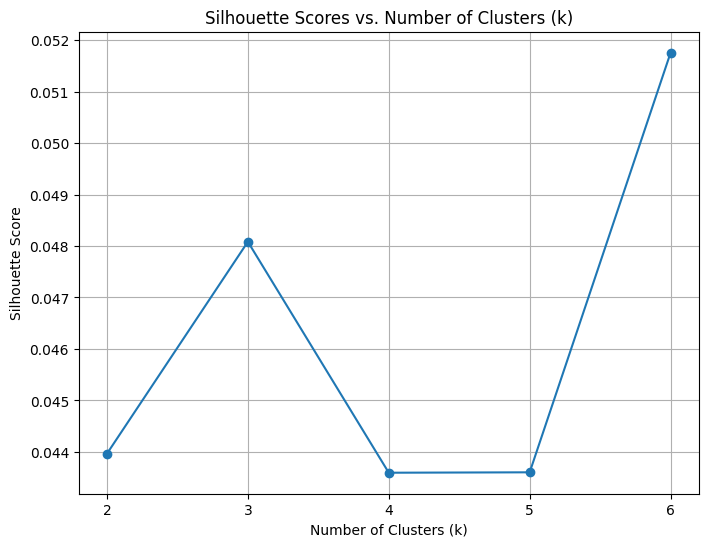

In [27]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Scores vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()

#### Identify the Best k

In [28]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULTS

# Based on the silhouette plot, the scores are relatively low for all tested k values,
# and there isn't a clear "elbow" or peak to definitively identify the best k.
# However, there's a slight increase in the score around k=3 and k=6.

#### Cluster the embeddings using 3 clusters (k=3)

In [29]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULTS

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10) # Set n_init explicitly
news_df_unique['CLUSTER_LABEL'] = kmeans.fit_predict(embeddings)

# Display the first few rows with the new cluster labels
display(news_df_unique.head())

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,URL,EMBEDDED_TEXT,EMBEDDINGS,CLUSTER_LABEL
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...,2025-07-24 09:03:00+00:00,https://finance.yahoo.com/news/3m-company-mmm-...,3M Company (MMM): “I Was Surprised” By The Org...,"[0.006455427, -0.109047554, -0.07995972, 0.026...",0
10,AOS,Earnings Beat: A. O. Smith Corporation Just Be...,Investors in A. O. Smith Corporation ( NYSE:AO...,2025-07-27 12:40:47+00:00,https://finance.yahoo.com/news/earnings-beat-o...,Earnings Beat: A. O. Smith Corporation Just Be...,"[-0.042056795, -0.04288128, -0.0032157362, 0.1...",1
20,ABT,Declining Stock and Solid Fundamentals: Is The...,It is hard to get excited after looking at Abb...,2025-07-27 11:02:42+00:00,https://finance.yahoo.com/news/declining-stock...,Declining Stock and Solid Fundamentals: Is The...,"[0.009079969, -0.06411803, 0.05312414, 0.01558...",2
30,ABBV,The Smartest Dividend Stocks to Buy With $350 ...,"These stocks offer juicy dividends, solid grow...",2025-07-26 08:50:00+00:00,https://www.fool.com/investing/2025/07/26/the-...,The Smartest Dividend Stocks to Buy With $350 ...,"[-0.038016543, -0.0910277, -0.009809815, 0.002...",2
40,ACN,Accenture’s (ACN) Oversold Status May Offer a ...,Accenture plc (NYSE:ACN) is included among the...,2025-07-26 03:44:43+00:00,https://finance.yahoo.com/news/accenture-acn-o...,Accenture’s (ACN) Oversold Status May Offer a ...,"[-0.07867279, -0.07679501, 0.06404918, 0.04737...",2


### Visualize the 2 first PCA Components of your embeddings

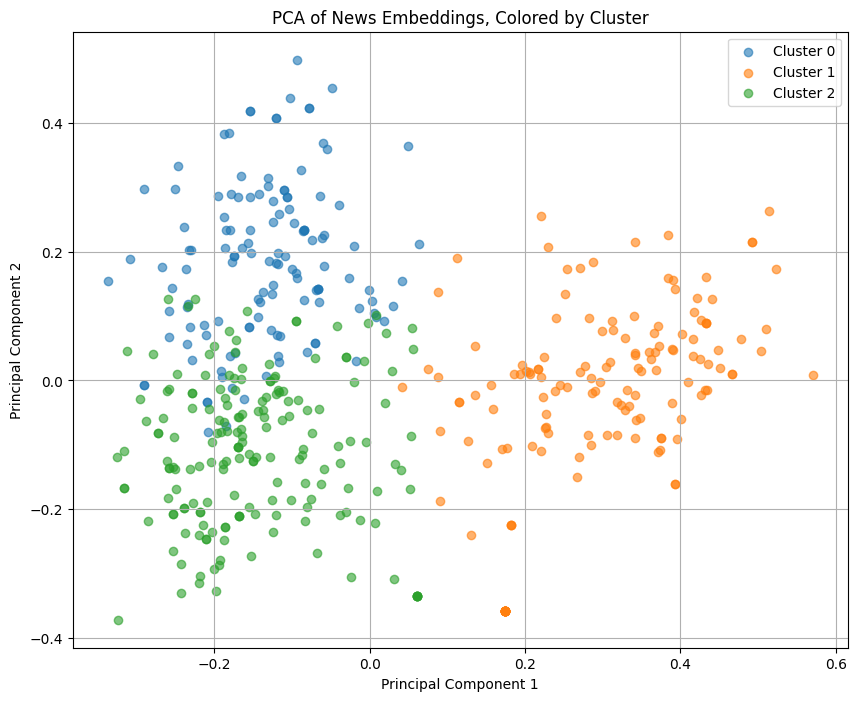

In [30]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULTS

# Perform PCA to reduce dimensions to 2
pca = PCA(n_components=2)
pca_components = pca.fit_transform(embeddings)

# Add the PCA components to the DataFrame for visualization
news_df_unique['PCA1'] = pca_components[:, 0]
news_df_unique['PCA2'] = pca_components[:, 1]

# Visualize the PCA components, colored by cluster label
plt.figure(figsize=(10, 8))

# Get unique cluster labels
cluster_labels = news_df_unique['CLUSTER_LABEL'].unique()

# Plot each cluster separately to create a discrete legend
for cluster_label in cluster_labels:
    cluster_data = news_df_unique[news_df_unique['CLUSTER_LABEL'] == cluster_label]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster_label}', alpha=0.6)

plt.title('PCA of News Embeddings, Colored by Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

#### Analyze the content of each cluster
- Add the kmeans cluster label to your news dataframe
- Print the content of each cluster and analyze it

In [31]:
# YOUR CODE HERE
# USE AS MANY CELLS AS YOU NEED
# MAKE SURE TO DISPLAY INTERMEDIARY RESULS

# Analyze the content of each cluster
for cluster_label in news_df_unique['CLUSTER_LABEL'].unique():
    print(f"--- Cluster {cluster_label} ---")
    cluster_news = news_df_unique[news_df_unique['CLUSTER_LABEL'] == cluster_label]
    # Display a few news items from each cluster
    display(cluster_news[['TICKER', 'TITLE', 'SUMMARY']].head())
    print("\n")

--- Cluster 0 ---


,TICKER,TITLE,SUMMARY
0,MMM,3M Company (MMM): “I Was Surprised” By The Org...,We recently published 12 Stocks Jim Cramer Tal...
100,APD,Green Hydrogen Boom Fizzles as Projects Collap...,"The hydrogen hype cools off, with the sector’s..."
110,ABNB,Airbnb's Cash Cow Can Thrive Despite Its Chall...,The short-term rental king is a major player i...
150,ALGN,"Align Technology, Inc. (ALGN): A Bull Case Theory",We came across a bullish thesis on Align Techn...
260,AXP,Citigroup enters credit card perk wars with $5...,Citigroup is once again courting high-end cred...




--- Cluster 1 ---


,TICKER,TITLE,SUMMARY
10,AOS,Earnings Beat: A. O. Smith Corporation Just Be...,Investors in A. O. Smith Corporation ( NYSE:AO...
90,A,Agilent Technologies' Q3 2025 Earnings: What t...,Agilent Technologies is expected to release it...
120,AKAM,Akamai Technologies Earnings Preview: What to ...,Akamai Technologies is prepared to release its...
160,ALLE,Allegion Second Quarter 2025 Earnings: Beats E...,Allegion ( NYSE:ALLE ) Second Quarter 2025 Res...
170,LNT,Alliant Energy’s Quarterly Earnings Preview: W...,Alliant Energy is set to report its second-qua...




--- Cluster 2 ---


,TICKER,TITLE,SUMMARY
20,ABT,Declining Stock and Solid Fundamentals: Is The...,It is hard to get excited after looking at Abb...
30,ABBV,The Smartest Dividend Stocks to Buy With $350 ...,"These stocks offer juicy dividends, solid grow..."
40,ACN,Accenture’s (ACN) Oversold Status May Offer a ...,Accenture plc (NYSE:ACN) is included among the...
50,ADBE,What Are the 3 Best Bargain Artificial Intelli...,Not all artificial intelligence (AI) stocks ha...
60,AMD,Own AMD stock? This Is the 1 Thing to Watch Now.,The stock could double in three years if AMD e...




## Question Section

Take time to reflect on what you've implemented and observed. Answer the following questions in a separate markdown cell or notebook file:

---

### Technical Understanding

#### 1️⃣ How might the choice of embedding model (e.g., MiniLM vs. a larger transformer) affect your clustering results and interpretation?

Using smaller models like MiniLM have less computational cost but may capture less semantic meaning compared to a larger transformer. The clustering may be less coherent with the small models and the interpretation of the grouping can be less accurate because of this.

---

#### 2️⃣ What would be the differences in embeddings if you used only the TITLE, only the SUMMARY, or the combination of both? How could you empirically test this?

By using only the title, the embeddings would only capture the core subject of the news, whereas with the summary you will get more details, leading to richer embeddings, but also introducing noise from less relevant information.
By using a combination of both you capture the best of both worlds, but this will increase the computational cost.
This could be tested by training the clustering models with three different sets of embeddings, (one for title, one for summary and one for the combination). At the end we can compare the silhouette scores and inspect the content of the clusters to see what makes the most sense.

---

#### 3️⃣ In what situations would using a different dimensionality reduction method (e.g., t-SNE, UMAP) be preferable over PCA for visualization of embeddings?

*   When the data is non-linear
*   For better 2D visualization
*   For high dimensional, sparse or complex data


---

### Data Analysis and Interpretation

#### 4️⃣ Based on your cluster analysis, identify at least two potential challenges you faced in interpreting the clusters and propose strategies to address them.

*   Low silhouette scores and overlapping clusters. We can try different clustering techniques like DBSCAN.

*   Hard to identify the labels for each cluster. We can identify keywords (like the example of the synchrounous session) within each cluster. Also display the most representative article for each cluster to help on interpretation.

---

#### 5️⃣ Did you observe any outliers in your 2D visualization? How would you identify and handle these outliers in a production pipeline?

Yes, there are some points that appear far away from the clusters. To identify these outliers we can use distance-based methods to measure how far away a point is from the cluster centroid and specify a threshold to label it as an outlier. We can handle the outliers by removing them or analyze them separately.

---

#### 6️⃣ If you could assign a 'label' or 'theme' to each cluster you obtained, what would they be? How confident are you in these assignments, and what could you do to validate them systematically?

*   Cluster 0 - Information about earnings
*   Cluster 1 - Updates on stock and companies
*   Cluster 2 - Recommendations

To validate them systematically, a manual review of some articles can be done, a keyword analysis per article, and cross check with some other data sources.

---

### Critical Thinking

#### 7️⃣ If news sentiment was incorporated into the analysis, how might this influence the clustering structure and interpretation of the clusters in a financial analysis context?

The sentiment would be another dimension for each cluster, specifying a combination of each cluster label with "positive, negative or neutral".
Examples:
*   Positive news about earnings.
*   Negative news about recommendations.
*   Neutral news about company updates.

---

#### 8️⃣ Discuss the limitations of using k-means clustering for news embeddings. What alternative clustering methods could address these limitations, and under what conditions would you prefer them?

It's hard to determine the quantity of clusters to use since the news could be grouped together under a lot of different criteria. Additionally, outliers can significantly affect the cluster centroids.
Alternative clustering methods can be:
*   DBSCAN (Density-Based Spatial Clustering of Applications with Noise). This method doesn't require specifying the number of clusters and can identify outliers as noise, as well manage clusters of irregular shapes.
*   GMM (Gaussian Mixture Models). This method allows for clusters of different sizes and densities, as well as cluster assignment based on probability. This method can be used when the clusters can be represented by Gaussian distributions and probabilistic assignments are preferred.



---

#### 9️⃣ How could the approach in this notebook be extended to analyze the potential impact of news clusters on stock price movements over time? Sketch a high-level pipeline you would implement to test this.

*   Data collection for the tickers we want to evaluate.
*   News embedding and clustering
*   Sentiment analysis
*   Perform an aggregation of the sentiment result per day (average sentiment per ticker per day)
*   Feature engineering (calculate technical indicators, volatility, complement list on type of sector / market, sentiment aggregation)
*   Model development with a time series model like ARIMA, LTSM, regression, to predict stock price movements based on the engineered features.
*   Evaluation of the models including metrics like RMSE and F1-score.
*   Compare the models that include the news impact versus models that don't.
*   Interpret the model's coefficients to see which ones are more predictive of stock movements.

---

#### 10️⃣ Imagine your clustering shows clear groups of news, but your downstream task (e.g., prediction of stock movement) does not improve. What might explain this disconnect between clear clusters and predictive utility?

*   Some clusters may not be financially relevant. For example some articles that talk about the social responsibility of the company will not affect a stock price movement.
*   The clustering doesn't have a clear temporal relationship with the stock price.
*   The clustering process may miss some important information that may be specific to a price change.
*   The predictive model may not be correctly capturing the relationship between the news and the stock price. A more complex model may be needed.
*   Limitation of the quantity and quality of the available news per ticker.
*   Existing market noise due to external factors beyond the news.


